In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.draw import draw_squares
from utils.square import SquareDataset
from torch.utils.data import DataLoader
import utils.viz as torchviz

In [2]:
class LinearModel(nn.Module):
    def __init__(self, x, y):
        super(LinearModel, self).__init__()
        self.layer1 = nn.Linear(x, y)

    def forward(self, x):
        x = self.layer1(x)
        return x

In [3]:
squares = SquareDataset(60000)
for i in range(5):
    print(squares[i])

(tensor([115.,  81.,  97., 143., 117.,  54., 245.,  72.,  50.]), tensor([0., 0., 1.]))
(tensor([  4., 223.,  70.,  56., 105.,  95.,  75.,  86.,  41.]), tensor([1., 0., 0.]))
(tensor([  1.,  13., 248., 161., 210.,  24.,   8., 124.,  42.]), tensor([0., 1., 0.]))
(tensor([ 18.,  83.,  36., 143., 218., 163.,  45., 205.,  59.]), tensor([0., 1., 0.]))
(tensor([130., 200., 214.,  67., 155.,  46., 246.,  52., 107.]), tensor([1., 0., 0.]))


# Using the not-so-smart Model

In [4]:
model = LinearModel(9, 3)
X = squares[4][0].reshape(-1, 9)/255
print(X)
print(model(X))

tensor([[0.5098, 0.7843, 0.8392, 0.2627, 0.6078, 0.1804, 0.9647, 0.2039, 0.4196]])
tensor([[-0.2050, -0.0188,  0.0037]], grad_fn=<AddmmBackward>)


In [5]:
model.layer1.weight, model.layer1.bias

(Parameter containing:
 tensor([[ 0.1059, -0.2351,  0.0255, -0.1972,  0.2625,  0.2541, -0.0858, -0.0655,
           0.1103],
         [ 0.2487, -0.0637,  0.2842,  0.2228, -0.2701, -0.0693,  0.0798, -0.2672,
           0.0266],
         [ 0.1608, -0.1205, -0.1233,  0.1524, -0.1639,  0.2395, -0.0632, -0.2412,
           0.3286]], requires_grad=True),
 Parameter containing:
 tensor([-0.1997, -0.2496,  0.1082], requires_grad=True))

# Looking at the gradients!

In [6]:
cost = torch.nn.MSELoss()
Y = squares[4][1].reshape(-1, 3)
loss = cost(model(X), Y)
print(loss)

tensor(0.4841, grad_fn=<MseLossBackward>)


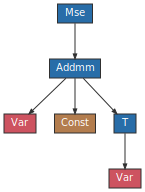

In [7]:
torchviz.draw(loss)

# Optimizing All Teh Things!

In [8]:
# Use the nn package to define our model and loss function.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LinearModel(9, 3)
model = model.to(device)

cost = torch.nn.MSELoss()

# optimizer which Tensors it should update.
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# dataset!
dataloader = DataLoader(squares, batch_size=128)

epochs = 20

# The Optimization Loop

In [9]:
for t in range(epochs):
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device) / 255, Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

    print('l: {:>8f}, (e {:>3})'.format(loss.item(), t))

l: 0.175322, (e   0)
l: 0.144956, (e   1)
l: 0.127325, (e   2)
l: 0.117154, (e   3)
l: 0.111338, (e   4)
l: 0.108053, (e   5)
l: 0.106228, (e   6)
l: 0.105239, (e   7)
l: 0.104723, (e   8)
l: 0.104470, (e   9)
l: 0.104359, (e  10)
l: 0.104324, (e  11)
l: 0.104325, (e  12)
l: 0.104342, (e  13)
l: 0.104366, (e  14)
l: 0.104389, (e  15)
l: 0.104410, (e  16)
l: 0.104427, (e  17)
l: 0.104442, (e  18)
l: 0.104454, (e  19)


In [10]:
print("W's and b's:")
for p in model.parameters():
    print(p)

W's and b's:
Parameter containing:
tensor([[ 0.5627,  0.5829,  0.5750, -0.2806, -0.2749, -0.2752, -0.2772, -0.2672,
         -0.2802],
        [-0.2565, -0.2729, -0.2635,  0.5925,  0.5858,  0.5760, -0.2636, -0.2734,
         -0.2683],
        [-0.2728, -0.2780, -0.2808, -0.2776, -0.2767, -0.2666,  0.5733,  0.5725,
          0.5784]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.2969, 0.2559, 0.2975], device='cuda:0', requires_grad=True)


# Trying it out (inference)